# Importing all the required libraries for this project

In [ ]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette("cubehelix")

In [ ]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1

Using TensorFlow backend.

This code defines a function called save_bottleneck_features(). This function's purpose is to extract and save "bottleneck features" from images using a pre-trained deep learning model called VGG16.

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

This function is designed to train a neural network model for a categorical classification task (meaning it's predicting one of several distinct categories).

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(277) + [1]*(314) + [2]*(385))
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(51) + [1]*(56) + [2]*(69))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

This function is designed to fine-tune a pre-trained VGG16 model for a categorical classification task. This means it takes a model that's already good at recognizing general image features and adapts it to be better at classifying specific categories relevant to your dataset.

In [ ]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

This Python code defines a function called print_best_model_results. Its purpose is to identify and display the best performance metrics achieved during the training of a machine learning model

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_acc'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

This function is designed to visualize the performance of a machine learning model during training. It takes the training history (hist) as input, which contains metrics like accuracy and loss recorded during each training epoch. The optional stop parameter (defaulting to 50) determines the number of epochs to display in the plots.

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

This function is designed to evaluate the performance of a trained categorical classification model on a given dataset.

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

    predictions = model.predict_generator(generator, len(labels))

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

# Image Dataset Details


This code snippet is essentially setting up important parameters and file paths for the image classification task. Think of it as defining the groundwork for the model to operate on

In [ ]:
location = '/content/drive/MyDrive/data4'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 976
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 176

img_width, img_height = 256,256
epochs = 50
batch_size = 16

This function, save_bottleneck_features, is designed to extract and save what are called "bottleneck features" from your image data. These features are essentially compressed representations of the images that capture the important information learned by a pre-trained deep learning model.

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    # Use predict instead of predict_generator
    bottleneck_features_train = model.predict(generator, steps=nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    # Use predict instead of predict_generator
    bottleneck_features_validation = model.predict(generator, steps=nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

This line is a function call. It's essentially telling the program to execute the code that's defined within the function named save_bottleneck_features

In [ ]:
save_bottleneck_features()

Found 1403 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
Found 248 images belonging to 3 classes.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


This line is updating where your model will save its learned weights by defining a new file name and path for them. The weights themselves are generated during the training process of your neural network model.

In [ ]:
top_model_weights_path = location+'/top_model_weights.weights.h5' # Changed the file name to end with .weights.h5

This line is calling the train_categorical_model() function, which is defined earlier in the code. This function is responsible for training a neural network model to classify images into different categories.

train_categorical_model(): This is the function being called. It executes the code within its definition to train the model.
d4_model: This variable will store the trained model itself. You can think of it as the final product of the training process.
d4_history: This variable stores the training history, which includes information like the model's accuracy and loss during each training step. This data is useful for evaluating the model's performance and identifying areas for improvement.
=: This is the assignment operator. It assigns the values returned by train_categorical_model() to the variables d4_model and d4_history

In [ ]:
d4_model, d4_history = train_categorical_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4057 - loss: 7.4065 - val_accuracy: 0.5057 - val_loss: 1.0013
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4378 - loss: 1.4895 - val_accuracy: 0.4545 - val_loss: 1.0263
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5162 - loss: 1.0960 - val_accuracy: 0.5170 - val_loss: 0.9328
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5162 - loss: 1.1100 - val_accuracy: 0.4148 - val_loss: 1.8219
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5658 - loss: 1.0473 - val_accuracy: 0.5909 - val_loss: 1.1658
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6554 - loss: 0.7723 - val_accuracy: 0.5625 - val_loss: 1.0166
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6637 - loss: 0.7771 - val_accuracy: 0.5227 - val_loss: 1.1348
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7051 - loss: 0.6812 - val_accuracy: 0.4716 - val_loss: 1.2409
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6897 - loss: 0.7140 - val_accuracy: 0.5398 - val_loss: 1.1294
Epo

The primary goal of this function, plot_metrics, is to visually represent the performance of a machine learning model over its training process. It does this by creating two plots: one for accuracy and one for loss.
In essence, this function takes the training history of a model and generates two plots to visualize its accuracy and loss over time, helping users understand how the model performed during training.

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    # Replace 'acc' with 'accuracy' and 'val_acc' with 'val_accuracy'
    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist) # Make sure print_best_model_results is also updated if needed

Purpose: This function creates two plots to visualize the model's training process:
One plot shows how the accuracy of the model changed over epochs, both for the training data and the validation data.
The other plot shows how the loss of the model changed over epochs, again for both training and validation data.
hist: Similar to the previous function, this is the training history input, expected to contain accuracy, val_accuracy, loss, and val_loss.
stop=50: This is an optional parameter that sets the maximum number of epochs to display in the plots. It defaults to 50.
fig, axes = plt.subplots(...): This line creates a figure and two subplots (axes) for the two plots.
axes[0].plot(...) and axes[1].plot(...): These lines plot the accuracy and loss data respectively, for both training and validation.
axes[0].set_title(...), axes[0].set_ylabel(...), etc.: These lines set the titles, labels, and legends for the plots to make them more informative.
plt.tight_layout(): This line adjusts the spacing of the plots so they don't overlap.
print_best_model_results(hist): After creating the plots, this line calls the print_best_model_results function (explained above) to display the best model metrics.
In summary, these two functions work together to:

Track the model's performance during training (accuracy and loss).
Identify the best performing epoch based on validation accuracy.
Visualize the training progress using plots.
**Print the best

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])  # Changed 'val_acc' to 'val_accuracy'
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_accuracy'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])  # Changed 'val_acc' to 'val_accuracy'

def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')  # Changed 'acc' to 'accuracy'
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')  # Changed 'val_acc' to 'val_accuracy'
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

This line is a function call that triggers the execution of the plot_metrics function, which is defined earlier in the code.

Best Model:
epoch: 26 , val_acc: 0.6079545617103577 , val_loss: 1.9835530519485474


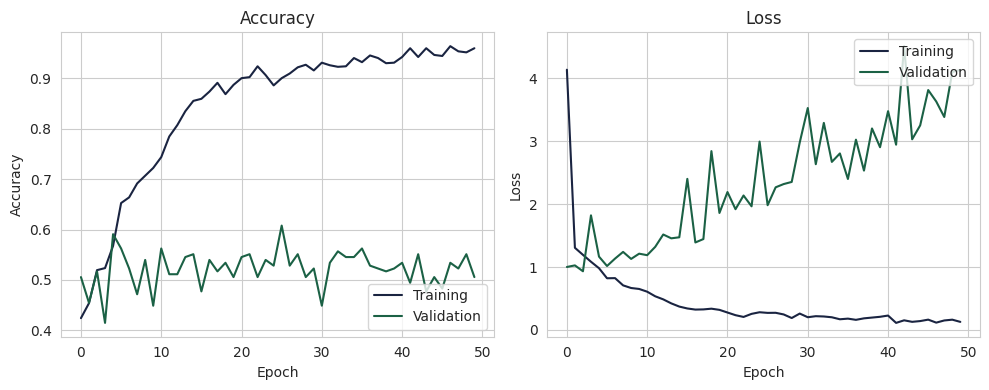

In [ ]:
plot_metrics(d4_history)

This function is the core of the transfer learning process, where a pre-trained model (VGG16) is adapted for a specific image classification task.

In [ ]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history

This function, finetune_categorical_model, is the heart of a process called transfer learning, specifically for image classification.

In [ ]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])



This code snippet is part of a larger function called finetune_categorical_model(). This function is designed to fine-tune a pre-trained neural network model (VGG16) for a specific image classification task

In [ ]:
def finetune_categorical_model():
    # ... (other parts of your function) ...
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), # Changed lr to learning_rate
                  metrics=['accuracy'])


 This function, finetune_categorical_model(), is designed to adapt a powerful image recognition model called VGG16 to a specific task of categorizing images into three distinct categories. This process is known as transfer learning.

In [ ]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # This line defines 'model'

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=['accuracy']) # Now you can compile

    # ... (rest of your finetune_categorical_model function) ...

This function, finetune_categorical_model, is designed to fine-tune a pre-trained VGG16 model for a specific image classification task. It's a key part of a process called transfer learning, where a model trained on a large dataset (like ImageNet) is adapted for a new, but related, task

In [ ]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # This line defines 'model'

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=['accuracy']) # Now you can compile

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') # Changed monitor to 'val_accuracy'

    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history # Returning the model and history

This code snippet is focused on modifying the finetune_categorical_model function, specifically the way it saves the trained mode

In [ ]:
def finetune_categorical_model():
    # ... (other parts of your function) ...

    # Change the file extension to .keras
    fine_tuned_model_path = location + '/ft_model.keras'

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    # ... (rest of your function) ...

 Python function finetune_categorical_model(). This function is designed to fine-tune a pre-trained VGG16 model for a specific image classification task.

In [ ]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # This line defines 'model'

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=['accuracy']) # Now you can compile

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    # Change the file extension to .keras
    fine_tuned_model_path = location + '/ft_model.keras'

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') # Changed monitor to 'val_accuracy'

    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history # Returning the model and history

 Python function finetune_categorical_model(). This function is designed to fine-tune a pre-trained VGG16 model for a specific image classification task.

In [ ]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Weights file incompatible. Starting with random weights.
Found 1403 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.3149 - loss: 3.7931
Epoch 1: val_accuracy improved from -inf to 0.41477, saving model to /content/drive/MyDrive/data4/ft_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 55s 854ms/step - accuracy: 0.3149 - loss: 3.7916 - val_accuracy: 0.4148 - val_loss: 2.4013
Epoch 2/50
27/61 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.3591 - loss: 3.7740

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.41477
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.3680 - loss: 3.6786 - val_accuracy: 0.3611 - val_loss: 2.5836
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3916 - loss: 3.7420
Epoch 3: val_accuracy improved from 0.41477 to 0.45455, saving model to /content/drive/MyDrive/data4/ft_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.3913 - loss: 3.7408 - val_accuracy: 0.4545 - val_loss: 2.3105
Epoch 4/50
27/61 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.3073 - loss: 4.0612
Epoch 4: val_accuracy did not improve from 0.45455
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.3334 - loss: 3.9765 - val_accuracy: 0.3333 - val_loss: 2.9261
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3535 - loss: 3.6207
Epoch 5: val_accuracy did not improve from 0.45455
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 339ms/step - accuracy: 0.3536 - loss: 3.6203 - val_accuracy: 0.4545 - val_loss: 2.3797


This code is designed to check if your trained model file (ft_model.keras) is present in the specified directory. It uses built-in Python functions to:

Construct the complete path to the file.
Verify if the file exists at that path.
Print an appropriate message informing you whether the file was found or not.

In [ ]:
import os

location = '/content/drive/MyDrive/data4'  # Adjust if needed
fine_tuned_model_path = os.path.join(location, 'ft_model.keras')

if os.path.exists(fine_tuned_model_path):
    print("File exists at:", fine_tuned_model_path)
else:
    print("File not found at:", fine_tuned_model_path)

File exists at: /content/drive/MyDrive/data4/ft_model.keras


 This code snippet attempts to load a pre-trained model from a file. If the file is found, the model is loaded into the ft_model variable. If the file is not found, a message is printed to the console. This is a common pattern for loading saved models in machine learning workflows.

In [ ]:
import os
location = '/content/drive/MyDrive/data4'
fine_tuned_model_path = os.path.join(location, 'ft_model.keras')  # construct absolute path

# Check if the file exists
if os.path.exists(fine_tuned_model_path):
    print("File exists at:", fine_tuned_model_path)
    ft_model = load_model(fine_tuned_model_path)  # Load using absolute path
else:
    print("File not found at:", fine_tuned_model_path)

File exists at: /content/drive/MyDrive/data4/ft_model.keras


This line is responsible for loading a pre-trained machine learning model from a file

In [ ]:
ft_model = load_model('/content/drive/MyDrive/data4/ft_model.keras')

This code is creating an array called validation_labels which will hold the true labels for your validation dataset. These labels are essential for evaluating how well your model is performing.

In [ ]:
validation_labels = np.array([0] * validation_samples[0] +
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

This function is designed to take an image path (image_path) and a trained model (model) as input, then predict the severity of damage in the image.

In [ ]:
def path4(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'minor', 1:'moderate', 2:'severe'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating severity of damage....Result:",d[key])
    print("Severity assessment complete.")

This line uses the Image function from the IPython.display module.

Purpose: Its purpose is to display an image within the Jupyter notebook.

In [ ]:
Image('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg')

This function takes an image path, downloads the image, preprocesses it for prediction, and returns results, making it suitable for evaluating image damage severity using a machine learning model. Let me know if you'd like more clarification on any specific part.

In [ ]:
import io
import requests
from PIL import Image

def path4(image_path, model):
    response = requests.get(image_path, stream=True)
    response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

    try:
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    except (PIL.UnidentifiedImageError, OSError) as e:
        print(f"Error opening image: {e}")
        return  # Stop further processing for this image

    # ... (rest of your original function code below)
    img = image.resize((256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) / 255
    # ...

This code snippet sets up the environment for loading images from URLs, handles potential errors during image loading, and performs initial preprocessing on the image data. This prepares the image for use with a machine learning model for tasks like image classification or damage assessment.

In [ ]:
!pip install Pillow
import io
import requests
from PIL import Image, UnidentifiedImageError  # Import UnidentifiedImageError

def path4(image_path, model):
    response = requests.get(image_path, stream=True)
    response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

    try:
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    except (UnidentifiedImageError, OSError) as e:  # Use UnidentifiedImageError directly
        print(f"Error opening image: {e}")
        return  # Stop further processing for this image

    # ... (rest of your original function code below)
    img = image.resize((256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) / 255
    # ...

This line is calling the function path4() and passing two arguments to it:

'https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg': This is a string representing the URL of an image of a damaged car. This is the image that the function will analyze.

ft_model: This variable likely holds the pre-trained and fine-tuned machine learning model that's been set up earlier in the code. The model is designed to assess the severity of damage in images of cars.

In [ ]:
path4('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg', ft_model)

Error opening image: cannot identify image file <_io.BytesIO object at 0x7bed39d00e00>


This code fetches an image from a URL, opens it using the Pillow library, and then displays it directly within the Jupyter notebook environment.

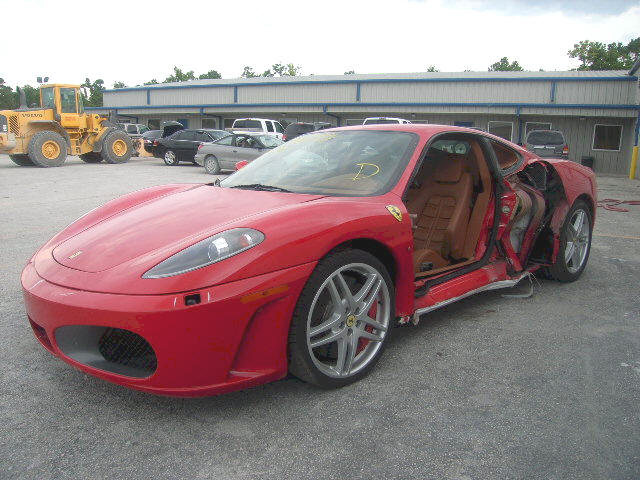

In [ ]:
from PIL import Image
from IPython.display import display
import requests
from io import BytesIO

# ... your code ...

# Assuming you want to display the image:
response = requests.get('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')
image = Image.open(BytesIO(response.content))
display(image)

This line is a function call that uses the previously defined function path4(). It aims to predict the severity of damage in an image of a wrecked Ferrari

In [ ]:
path4('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

This code is all about displaying an image from a URL within a Jupyter notebook. It imports the necessary tools, creates an Image object that points to the image online, and then uses the display function to render that image in your notebook. It provides two ways to achieve this, with the second way being a shorter, single-line option

In [ ]:
from IPython.display import Image, display

# To display an image from a URL:
image = Image(url='https://di-uploads-pod1.dealerinspire.com/depaulachevy/uploads/2015/07/Scratch-2.jpg')
display(image)

# Or, if you prefer a single line:
display(Image(url='https://di-uploads-pod1.dealerinspire.com/depaulachevy/uploads/2015/07/Scratch-2.jpg'))

This code is designed to robustly load an image from a URL, especially for use in a machine learning context. It's part of a function called path4() which likely does further processing on the image (like prediction using a model).

In [ ]:
import io
import requests
from PIL import Image, UnidentifiedImageError  # Import Image from PIL

# ... (rest of your code) ...

def path4(image_path, model):
    response = requests.get(image_path, stream=True)
    response.raise_for_status()

    try:
        # Use Image.open from PIL to open the image
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error opening image: {e}")
        return

    # ... (rest of your function code) ...

This line is a function call. It's how you tell Python to execute a specific function you've defined.

In [ ]:
path4('https://di-uploads-pod1.dealerinspire.com/depaulachevy/uploads/2015/07/Scratch-2.jpg', ft_model)